# Morris-Lecar Model

### model is described using two variables V and n.

## ${Cm}\frac{dV}{dt} = {I_{app}} - {g_{l}}({V} - {E_{l}}) -{g_{k}}{n}({V} - {E_{k}}) - {g_{Ca}}{m_{\infty}}({V} - {E_{Ca}})$


## $\frac{dn}{dt} = \frac{\phi({n_{\infty}(V)} - {n})} {\tau_{n}(V)}  $

## Where 
## $ {m_{\infty}(V)} = \frac{1}{2}(1 + {\tanh(\frac{V - V1}{V2})})  $
## $ {n_{\infty}(V)} = \frac{1}{2}(1 + {\tanh(\frac{V - V3}{V4})})  $
## $ {\tau_{n}(V)} = \frac{1}{\cosh(\frac{V - V3}{2V4})} $
### Here we are taking V as var1 and n as var2 in the code

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [87]:
def get_next_state(prev_state,model_params,dt):
# Each state is a pair (var1,var2) describing current value of DE variables
#      d (var1)/dt = f(var1, var2)
#      d (var2)/dt =  g(var1,var2)
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    minf = 0.5*(1 + np.tanh((prev_state[0] - V1)/V2))
    ninf = 0.5*(1 + np.tanh((prev_state[0] - V3)/V4))
    ntau = 1/(np.cosh((prev_state[0] - V3)/(2*V4)))
    curr_state = np.zeros(2)
    curr_state[0] = prev_state[0] + dt*(I - gl*(prev_state[0] - el)- gk*prev_state[1]*(prev_state[0]-ek) - gca*minf*(prev_state[0] - eca))/cm
    curr_state[1] = prev_state[1] + dt*(phi*(ninf - prev_state[1])/ntau)
    return curr_state

In [88]:
# get all values of var2 for the given range of var1 when d (var1)/dt = 0
def get_var1_nullcline(model_params,var1_range):
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    var1_nullcline = np.zeros(len(var1_range))
    for i in range(len(var1_range)):
        minf = 0.5*(1 + np.tanh((var1_range[i] - V1)/V2))
        var1_nullcline[i] = (I - gl*(var1_range[i] - el) - gca*minf*(var1_range[i] - eca))/(gk*(var1_range[i] - ek))
    return var1_nullcline

In [89]:
# get all values of var2 for the given range of var1 when d (var2)/dt = 0
def get_var2_nullcline(model_params,var2_range):
    phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I = model_params
    var2_nullcline = np.zeros(len(var2_range))
    for i in range(len(var2_range)):
        var2_nullcline[i] = V4*np.arctanh(2*var2_range[i] - 1) + V3
    return var2_nullcline

In [90]:
def find_freq(states):
    var1=states[:,0]
    freq=len(find_peaks(var1)[0])
    if freq>0:
        T = 2000
        tscale = T/freq
        fscale = 1/tscale
    else:
        fscale=0
    
    return fscale

In [91]:
tstop = 2000 # time to simulate
dt = .1 #ms discrete time step
#params = [a,b,c,d,e....]
#Hopf Type-2
#phi,gca,V3,V4,eca,ek,el,gk,gl,V1,V2,cm,I
params_hopf = [0.04,4.4,2,30,120,-84,-60,8,2,-1.2,18,20,90] #Hopf
params_snlc = [0.067,4,12,17.4,120,-84,-60,8,2,-1.2,18,20,40] #SNLC
params_homoclinic = [0.23,4,12,17.4,120,-84,-60,8,2,-1.2,18,20,40] #Homoclinic

Parameters are  [0.04, 4.4, 2, 30, 120, -84, -60, 8, 2, -1.2, 18, 20, 90]


<ipython-input-89-6119ca3a2959>:6: RuntimeWarning: invalid value encountered in arctanh
  var2_nullcline[i] = V4*np.arctanh(2*var2_range[i] - 1) + V3


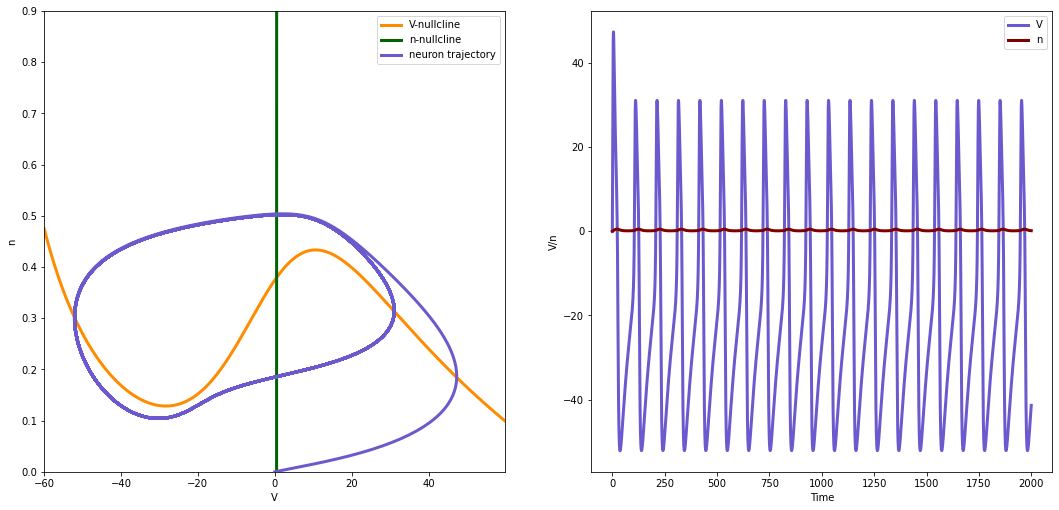

<Figure size 432x288 with 0 Axes>

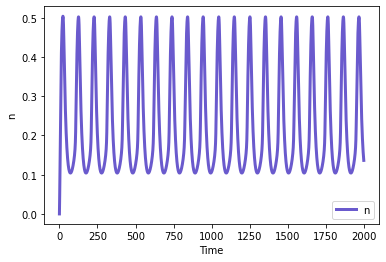

Parameters are  [0.067, 4, 12, 17.4, 120, -84, -60, 8, 2, -1.2, 18, 20, 40]


<ipython-input-89-6119ca3a2959>:6: RuntimeWarning: invalid value encountered in arctanh
  var2_nullcline[i] = V4*np.arctanh(2*var2_range[i] - 1) + V3


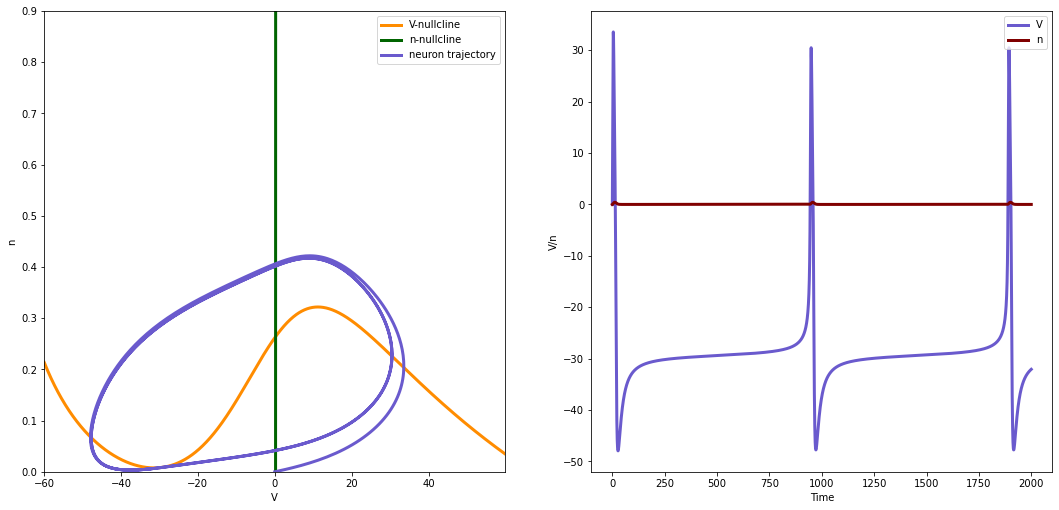

<Figure size 432x288 with 0 Axes>

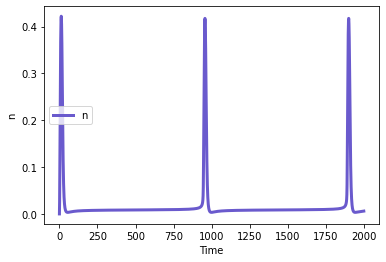

Parameters are  [0.23, 4, 12, 17.4, 120, -84, -60, 8, 2, -1.2, 18, 20, 40]


<ipython-input-89-6119ca3a2959>:6: RuntimeWarning: invalid value encountered in arctanh
  var2_nullcline[i] = V4*np.arctanh(2*var2_range[i] - 1) + V3


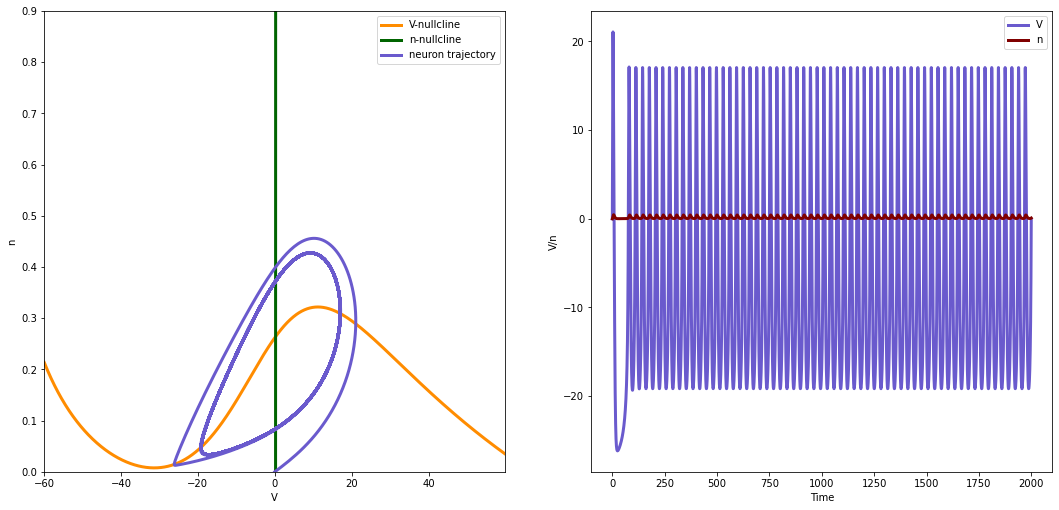

<Figure size 432x288 with 0 Axes>

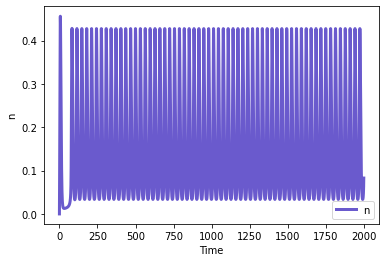

In [110]:
# Each state is a pair (var1,var2) describing current value of DE variables
#      d (var1)/dt = f(var1, var2)
#      d (var2)/dt =  g(var1,var2)
states = np.zeros((int(tstop/dt),2)) 
for param in [params_hopf,params_snlc,params_homoclinic]:
    print("Parameters are ",param)
    for i in range(states.shape[0]):
        if i==0:
            states[i,:] = [0,0]
        else:
            states[i,:] = get_next_state(states[i-1,:],param,dt)
    A = 0
    B = 100
    for current in range(A,B):
        freq=find_freq(states)

    range1 = np.arange(-60,60,0.1) #Change Range
    range2 = np.arange(0,1,0.1) #Change Range
    
    # Create a figure with two pairs of axes for phase plot and time plot
    fig = plt.figure(figsize = [16,8])
    phax = fig.add_axes([.075,.1,.4,.8])
    timax = fig.add_axes([.55,.1,.4,.8])
    fig2 = plt.figure()
    #fiax = fig2.add_subplot(111)
    # Display nullcline and trajectory of neuron in phase space
    phax.plot(range1,get_var1_nullcline(param,range1),color='darkorange',linewidth=3,label='V-nullcline')
    phax.plot(range1,get_var2_nullcline(param,range1),color='darkgreen',linewidth=3,label='n-nullcline')
    phax.plot(states[:,0],states[:,1],color='slateblue',linewidth=3,label='neuron trajectory')

    # Display trajectory of var1 and var2 with time
    timax.plot(np.arange(0,tstop,dt),states[:,0],color='slateblue',linewidth=3,label='V')
    timax.plot(np.arange(0,tstop,dt),states[:,1],color='maroon',linewidth=3,label='n')


    # fiax.plot(state_I,state_f,color='maroon',linewidth=3)

    # Set legends and other graph parameters
    phax.set_xlabel('V')
    phax.set_ylabel('n')
    timax.set_xlabel('Time')
    timax.set_ylabel('V/n')
    phax.set_xlim(min(range1),max(range1))
    phax.set_ylim(min(range2),max(range2))
    phax.legend(loc=0)
    timax.legend(loc=0)
    plt.show()
    plt.plot(np.arange(0,tstop,dt),states[:,1],color='slateblue',linewidth=3,label='n')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('n')
    plt.show()